In [1]:
class Point:
    def __init__(self, x=None, y=None):        
        self.coord = None
        if (x is not None) and (y is not None):
            self.coord = (x,y)
        else:
            self.coord = (10,10) #int(random.random() * 200)



In [33]:
import numpy as np

class Individ:
    def __init__(self, step, size): #, start_point, end_point, our_field):
        self.route = np.random.randint(-1,2, size=(2,size))*step  #   step*(-1) / step*1 / step*0
        self.individ_size = size
        self.fitness = 0
        self.setfitness()
        
    def setfitness(self): #, start_point, end_point, our_field):   #start_point = (x,y)
        global start_point
        global end_point
        global gameField
        cumsum = np.cumsum(self.route, axis=1) + np.array(start_point).reshape((2,1))
        index = self.checkblocks(cumsum, gameField)
        #print ('cumsum ', cumsum[:, index])
        distance = np.linalg.norm(cumsum[:, index] - np.array(end_point))      
        self.fitness = distance    # check normalization   
        
    def getfitness(self):
        return self.fitness
    
    def checkblocks(self, cumsum, our_field):
        global gameField
        for i in range(1, self.individ_size):
            if (any(cumsum[:, i] < 0) or (cumsum[0, i] >= gameField.field_size[0]) or (cumsum[1, i] >= gameField.field_size[1])):
                return i-1 
            elif gameField.getvalue(cumsum[0, i], cumsum[1, i]):
                return i-1
        return self.individ_size-1
    
    def getFinalRoute(self):
        global start_point
        global end_point
        global gameField
        cumsum = np.cumsum(self.route, axis=1) + np.array(start_point).reshape((2,1))
        index = self.checkblocks(cumsum, gameField)
        return cumsum[:, :index+1]
    
        

In [30]:
class Field:
    def __init__(self, size):
        self.matrix = np.zeros(size)
        self.matrix[0, :] = 1
        self.matrix[:, 0] = 1
        self.matrix[:, size[1]-1] = 1
        self.matrix[size[0]-1, :] = 1
        self.field_size = size
    
    def addSquareBlock(self, left_top, right_bottom):  #point = (x,y)
        for i in range(left_top[0], right_bottom[0]):
            for j in range(left_top[1], right_bottom[1]):
                self.matrix[i, j] = 1
                
    def addCircle(self, center, radius): # center = (x,y)
        for i in range(min(0,center[0]-radius), max(self.field_size[0],center[0]+radius)):
            for j in range(min(0,center[1]-radius), max(self.field_size[1],center[1]+radius)):
                if (center[0]-i)**2+(center[1]-j)**2 <= radius**2:
                    self.matrix[i, j] = 1
    
    # add diff shapes of blocks
        
    def getmatrix(self):
        return self.matrix
    
    def getvalue(self,x,y):
        return self.matrix[x,y]
    
        
        

In [4]:
import operator

class Population:
    def __init__(self, step, individSize, populationSize): #, start_point, end_point, our_field):
        self.population = []
        #self.fitness = []
        for i in range(0, populationSize):
            newInd = Individ(step, individSize) #, start_point, end_point, our_field)
            self.population.append(newInd)            
            #self.fitness.append(newInd.fitness)
                
    def getFitness(self):
        fitness = [x.fitness for x in self.population]
        return fitness
        #return self.fitness
    
    def getBest(self,n):        
        #sortedPopulation = [pop for _,pop in sorted(zip(self.fitness, self.population), key = lambda x: x[0])]    
        sortedPopulation = sorted(self.population,key=operator.attrgetter("fitness"))
        if n==1:
            return sortedPopulation[0]
        else:
            return sortedPopulation[:n]
    
    def add_individ(self, newIndivid):
        self.population.append(newIndivid)
        #self.fitness.append(newIndivid.fitness)
    
        
    
    

In [5]:
import random
import copy

class GA:
    def __init__(self, user_mutationRate, user_crossoverProbability, user_elitism):#, start_point, end_point, our_field): #, tourmanager):
        #self.tourmanager = tourmanager
        self.mutationRate = user_mutationRate
        #self.tournamentSize = 10
        self.crossoverProbability = user_crossoverProbability
        self.elitism = user_elitism
        #self.start_point = start_point
        #self.end_point = end_point
        #self.our_field = our_field
        
    def CreateFirstPopulation(self, user_step, user_individSize, user_populationSize):
        initialPop = Population(step=user_step, individSize=user_individSize, populationSize=user_populationSize) 
                                #start_point=self.start_point, end_point=self.end_point, our_field=self.our_field)
        return initialPop
        
    def chooseParents(self, generation):
        #print ('parent fitness ', newPopulation.fitness)
        reversed_fitness = 1.0/np.array(generation.getFitness())
        select_prob = reversed_fitness/sum(reversed_fitness)
        #print ('select prob ', select_prob)
        #add tournamentsize
        selected = np.random.choice(generation.population, 2, replace=False)#p=select_prob, replace=False)
        return list(selected)
    
    def get_breakes(self,n):
        break1,break2 = random.sample(range(0, n), 2)
        if break1<break2: 
            return(break1,break2)
        else:
            return(break2,break1)
    
    def crossover(self, parents):        
        #print('fitness parent 1 ', parents[0].fitness)
        #print('fitness parent 2 ', parents[1].fitness)
        children = copy.deepcopy(parents)
        #print('children ',children)
        #print('parents ',parents)
        pp = random.random()
        #print('route before crossover ', parents[0].route)
        if pp <= self.crossoverProbability:  
            startPos,endPos = self.get_breakes(parents[0].individ_size)
            #print('breaks ', startPos, endPos) 
            children[0].route[:, startPos:endPos], children[1].route[:, startPos:endPos] = \
                copy.deepcopy(children[1].route[:, startPos:endPos]), copy.deepcopy(children[0].route[:, startPos:endPos])            
            #print('crossover yes')
            #print('route after crossover ', children[0].route)
        
        return children
    
    def mutate(self, children):
        if random.random() < self.mutationRate:
            indx = random.randint(0, children[0].individ_size-1)
            children[0].route[0, indx], children[0].route[1, indx] = children[0].route[1, indx].copy(), children[0].route[0, indx].copy()
            #print('child one mutate')
            #print('route after mutation 1 ', children[0].route)
        if random.random() < self.mutationRate:
            indx = random.randint(0, children[1].individ_size-1)
            children[1].route[0, indx], children[1].route[1, indx] = children[1].route[1, indx].copy(), children[1].route[0, indx].copy()
            #print('child two mutate')
            #print('route after mutation 1 ', children[1].route)
            
        return children
    
    def fittest(self, child_list, n): # n - how much return
        child_list.sort(key = lambda x: x.fitness)
        return child_list[:n]
              
        
    def evolve(self, step, individSize, populationSize, generation, user_chooseFromAll):  #generation - previous population

        children_list = []
        for i in range(populationSize):
            #choose parents
            parents = self.chooseParents(generation)

            #make 2 children
            children = self.crossover(parents)

            #mutate
            children = self.mutate(children)

            children[0].setfitness()#self.start_point, self.end_point, self.our_field)
            children[1].setfitness()#self.start_point, self.end_point, self.our_field)
            
            #print('fitness children 1 ', children[0].fitness)
            #print('fitness children 2 ', children[1].fitness)

            children_list = children_list + children
        
    
        #Create new generation with elitism?
        if user_chooseFromAll:
            newPopulation = Population(step = step, individSize = individSize, populationSize = 0) 
                                       #start_point = self.start_point, end_point = self.end_point, our_field = self.our_field)
            for child in children_list:
                generation.add_individ(child)
            best_individs = generation.getBest(populationSize)
            for individ in best_individs:
                newPopulation.add_individ(individ)
        else:
            newPopulation = Population(step = step, individSize = individSize, populationSize = 0) 
                                       #start_point = self.start_point, end_point = self.end_point, our_field = self.our_field)
            if self.elitism:
                newPopulation.add_individ(generation.getBest(1))                
                best_children = self.fittest(children_list, populationSize-1)
            else:
                best_children = self.fittest(children_list, populationSize)
            for child in best_children:
                newPopulation.add_individ(child)       
               
        #print('new population fitness', newPopulation.fitness)
        #print('new population size', len(newPopulation.population))                  
        return newPopulation
        

In [49]:
# common parameters for all users
gameField = Field(size = (100, 100))
gameField.addSquareBlock((20,20),(40,50))
gameField.addCircle((70,70),10)
#start_point = Point(x = 2, y = 2)
#end_point = Point(x = 100, y = 100)
start_point = (10, 10)
end_point = (90, 90)

# parameters of one user
mutationRate=0.05
crossoverProbability=0.7
elitism=True
step=2
individSize=150
populationSize=100
chooseFromAll = False
#chooseFromAll = True

ga = GA(user_mutationRate=mutationRate, user_crossoverProbability=crossoverProbability, user_elitism=elitism) 
       # start_point=startpoint, end_point=endpoint, our_field=gameField)
initialPop = ga.CreateFirstPopulation(user_step=step, user_individSize=individSize, user_populationSize=populationSize)

print('evolve function: ')
while not any(np.array(initialPop.getFitness()) ==0):
#for i in range(0,100):
    initialPop = ga.evolve(step = step, individSize = individSize, populationSize = populationSize, generation = initialPop, 
                          user_chooseFromAll = chooseFromAll)    
    #print('all fitness ', initialPop.getFitness())
    print('min fitness ', min(initialPop.getFitness()))

best_individ = initialPop.getBest(1)

evolve function: 
min fitness  84.3800924389
min fitness  84.3800924389
min fitness  84.3800924389
min fitness  84.3800924389
min fitness  78.8923316933
min fitness  70.4556598152
min fitness  68.8186021363
min fitness  67.2011904656
min fitness  67.2011904656
min fitness  56.3560112144
min fitness  52.3450093132
min fitness  44.0454310911
min fitness  39.6988664826
min fitness  39.4461658466
min fitness  31.0483493925
min fitness  26.0
min fitness  26.0
min fitness  26.0
min fitness  19.6977156036
min fitness  16.1245154966
min fitness  10.1980390272
min fitness  10.1980390272
min fitness  10.1980390272
min fitness  10.1980390272
min fitness  10.1980390272
min fitness  2.0
min fitness  2.0
min fitness  2.0
min fitness  0.0


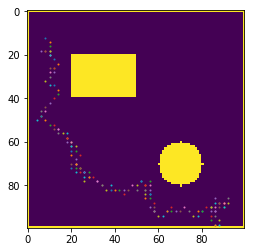

In [50]:
import matplotlib.pyplot as plt
route = best_individ.getFinalRoute()
fig, ax = plt.subplots()
ax.imshow(gameField.matrix)
for i in range(len(route[0])):
    ax.scatter(route[0][i], route[1][i],s=1)
plt.show()
#fig.savefig('test.png',dpi=500)